In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp('The 22-year-old recently won ATP Challenger tournament')

for tok in doc:
  print(tok.text,'....',tok.dep_)

The .... det
22-year .... npadvmod
- .... punct
old .... nsubj
recently .... advmod
won .... ROOT
ATP .... compound
Challenger .... compound
tournament .... dobj


EXTRACT RELATIONS

In [ ]:
doc = nlp('Nagal won the first set.')

for tok in doc:
  print(tok.text,'....',tok.dep_)

Nagal .... nsubj
won .... ROOT
the .... det
first .... amod
set .... dobj
. .... punct


## **Build a Knowledge Graph from Text Data**

In [ ]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth',200)
%matplotlib inline

## Read data

In [ ]:
sentences = pd.read_csv('wiki_sentences_v2.csv')
sentences.shape

(4318, 1)

In [ ]:
sentences['sentence'].sample(5)

2739                                        stage plays are frequent sources for film adaptations. 
3651                                                                   warren skaaren did rewrites.
2865                                    nikkatsu responded by discontinuing their roman porno line.
1162                                                            nushrat bharucha cast opposite him.
3351    the farabi cinema foundation then stepped in to try and reassemble the disorganized cinema.
Name: sentence, dtype: object

## Checking the subject and object

In [ ]:
doc = nlp('the drawdown process is governed by astm standard d823')

for tok in doc:
  print(tok.text,'....',tok.dep_)

the .... det
drawdown .... amod
process .... nsubjpass
is .... auxpass
governed .... ROOT
by .... agent
astm .... compound
standard .... amod
d823 .... pobj


## Entity Pairs Extaction

In [ ]:
def get_entities(sent):
  #piece1
  entr1 = ''
  entr2 = ''

  prv_tok_dep  = ''       #dependency tag of previous token in the sentences
  prv_tok_text = ''       #previous token in the sentences

  prefix   = ''
  modifier = ''

  ################################################################

  for tok in nlp(sent):
    #piece2
    #if token is a punctuation then move on to next token

    if tok.dep_ != 'punct':

      if tok.dep == 'compound':
        prefix = tok.text
        
        if prv_tok_dep == 'compound':
          prefix = prv_tok_dep+' '+prefix

      if tok.dep_.endswith('mod') == True:
        modifier = tok.text
        if prv_tok_dep == 'compound':
          modifier = prv_tok_text+' '+tok.text

      #piece3
      if tok.dep_.find('subj') == True:
        entr1 = modifier +' '+prefix+' '+tok.text

        prefix       = ''
        modifier     = ''
        prv_tok_dep  = ''
        prv_tok_text = ''

      #piece4
      if tok.dep_.find('obj') == True:
        entr2 = modifier +' '+prefix+' '+tok.text

        prefix       = ''
        modifier     = ''
        prv_tok_dep  = ''
        prv_tok_text = ''
      #piece5
      #update variables
      prv_tok_dep  = tok.dep_
      prv_tok_text = tok.text
  ##################################################################
  return [entr1.strip(),entr2.strip()]

In [ ]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [ ]:
entity_pairs = []

for i in tqdm(sentences['sentence']):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:28<00:00, 151.94it/s]


In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['global', 'international  rights'],
 ['robertson', 'soundtrack'],
 ['it', 'original  tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [ ]:
sentences['sentence'][10:20]

10                                       we went through all these tests and things  
11       m global was also circling to bid for the film's international sales rights.
12                      canadian musician robbie robertson supervised the soundtrack.
13                               it features both original and existing music tracks.
14                                    it is the worst reviewed film in the franchise.
15    but she injures quicksilver and accidentally kills mystique before flying away.
16                                            military forces tasked with her arrest.
17                                the train is attacked by vuk and her d'bari forces.
18                                    kota eberhardt portrays telepath selene gallio,
19                                 singer did not return to direct the sequel, x-men:
Name: sentence, dtype: object

## Relation Predicate/Extraction

In [ ]:
def get_relation(sent):
  doc = nlp(sent)

  #Matcher class object
  matcher = Matcher(nlp.vocab)

  #define the patern
  pattern = [{'DEP':'ROOT'},
             {'DEP':'prep','OP':'?'},
             {'DEP':'agent','OP':'?'},
             {'POS':'ADJ','OP':'?'}]
  
  matcher.add('matching_1',None,pattern)

  matches = matcher(doc)
  k = len(matches) - 1
  span = doc[matches[k][1]:matches[k][2]]

  return span.text

In [ ]:
get_relation('John completed the task')

'completed'

## Relations of all wikipedia sentences

In [ ]:
relations = [get_relation(i) for i in tqdm(sentences['sentence'])]

100%|██████████| 4318/4318 [00:28<00:00, 152.27it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
are               71
were              71
released          40
's                38
composed by       35
has               31
became            31
have              31
become            29
released in       27
included          26
called            22
produced          22
considered        20
made              20
had               20
be                18
been              18
scheduled         17
used              17
stars             16
directed by       16
written by        15
hired             14
wrote             14
set               14
produced by       14
introduced in     13
received          13
went              13
wanted            12
began in          11
won               11
began             11
features          10
sold              10
gave              10
known as           9
reported           9
gives              9
includes           9
directed           9
shot in            9
opened       

## Build a Knowledge Graph

In [ ]:
#extract subject
source = [i[0] for i in entity_pairs]

#extract object
target = [i[1] for i in entity_pairs]

kgdf = pd.DataFrame({'source':source, 'target':target, 'edge':relations})


In [ ]:
#ceate a directed graph from dataframe
G = nx.from_pandas_edgelist(kgdf, 'source', 'target', edge_attr = True, create_using = nx.MultiDiGraph())

## Plot the Network

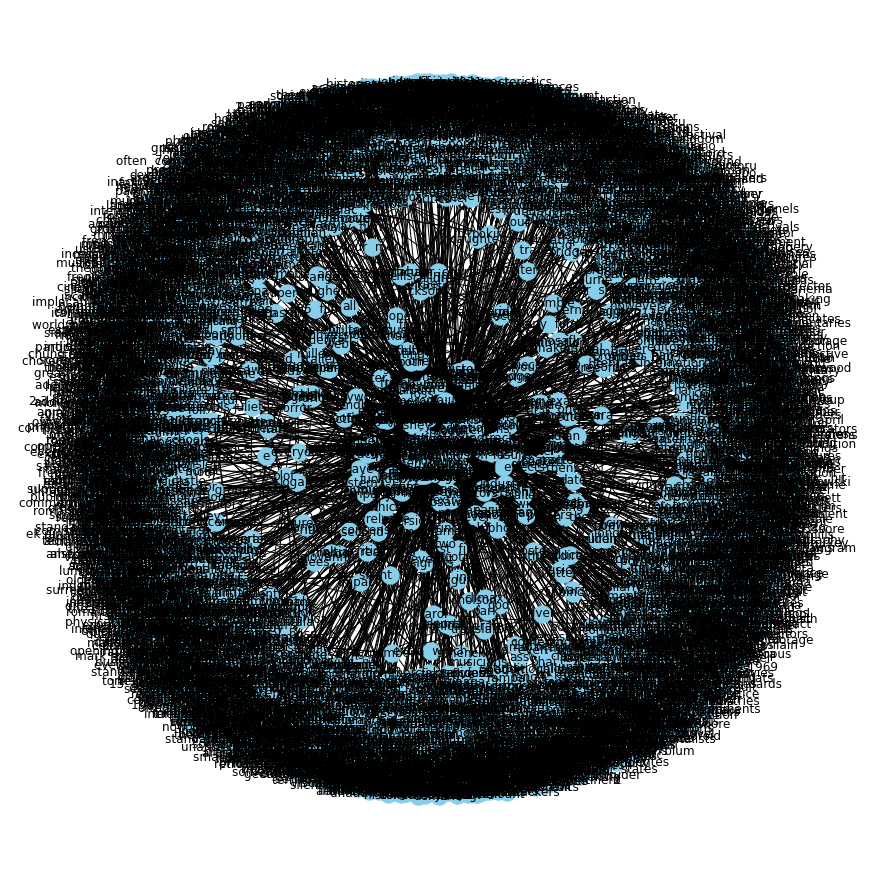

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()

# Plotting the nodes only connected by 'composed' edge

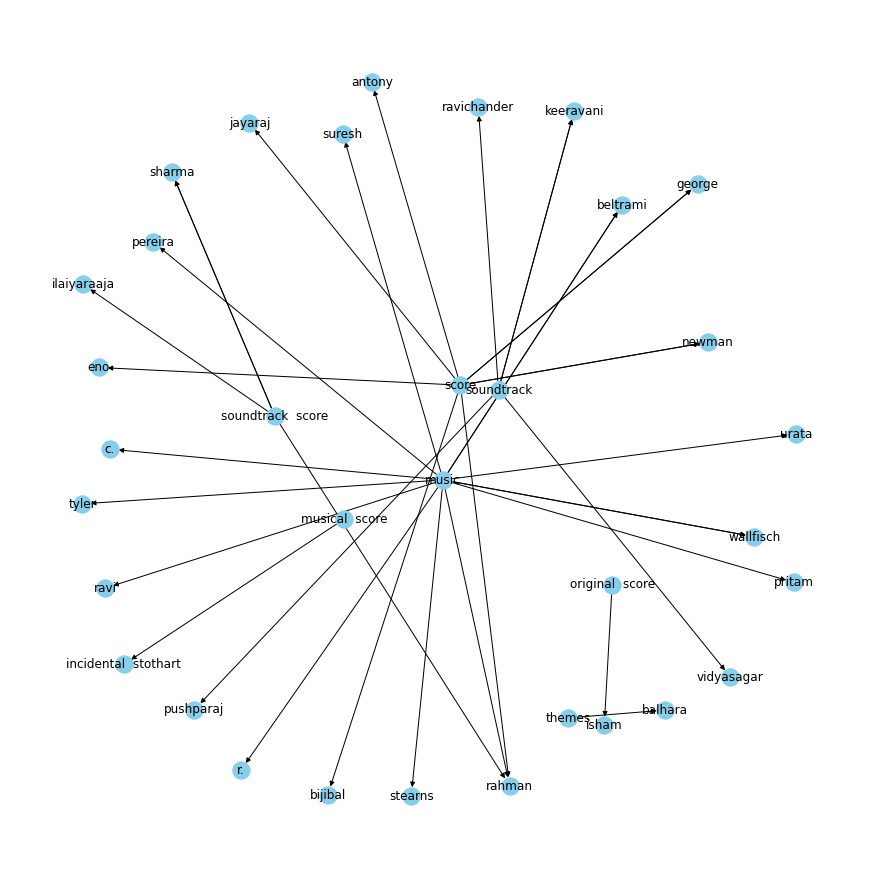

In [ ]:
G = nx.from_pandas_edgelist(kgdf[kgdf['edge']=='composed by'], 'source', 'target', edge_attr = True, create_using = nx.MultiDiGraph())

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G, k = 0.5)  #k regulates the distance between the nodes
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos=pos)
plt.show()